# LERM applied to synthetic ODP cores

This notebook recreates Figure 3 from the original publication, applying LERM to synthetic ODP cores.

In [1]:
import pickle

import pyleoclim as pyleo
import numpy as np
import ammonyte as amt
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

The workflow in this notebook is largely identical to that of Figure 2, only the creation of the data varies significantly as we now use synthetic data binned onto the time axes of the ODP data.

In [3]:
#Defining group lists for easy loading
group_names = ['ODP 925','ODP 927','ODP 929','ODP 846','ODP 849']

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


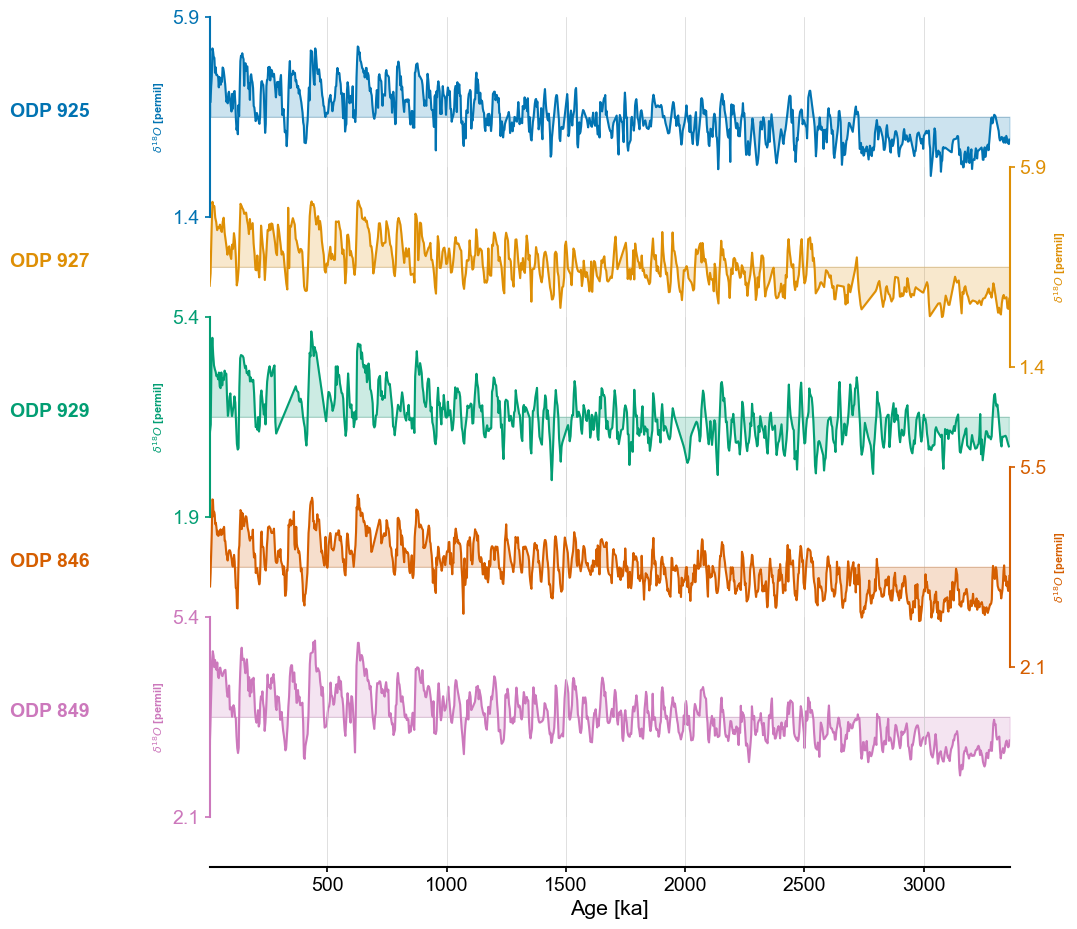

In [4]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('../data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,10))

In [5]:
#Initialize line colors
line_colors = []
fill_colors = []

for i in range(10):
    line_colors.append(sns.color_palette('colorblind')[i])
    fill_colors.append(sns.color_palette('colorblind')[i])

In [6]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

In [7]:
with open('../data/0_2500_I65_staged.pkl','rb') as handle:
    initial_series = pickle.load(handle)

In [8]:
lp_series_list = []
syn_series_list = []
m = 13 # Embedding dimension

for idx,series in enumerate(ms.series_list):
    core_series = series.slice((min(initial_series.time),max(initial_series.time)))
    binned_series = initial_series.bin(time_axis=core_series.time).convert_time_unit('Years').detrend(method='savitzky-golay')
    syn_series_list.append(binned_series)
    td = amt.TimeEmbeddedSeries(series=binned_series.interp(),m=m)
    print(f'{series.label} tau is : {td.tau}')
    eps = td.find_epsilon(eps=1,target_density=.05,tolerance=.01)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(w_size=50,w_incre=5).convert_time_unit('ka')
    lp_series.label = series.label
    lp_series.value_name='FI'
    lp_series.value_unit='NA'
    lp_series_list.append(lp_series)

syn_ms = pyleo.MultipleSeries(syn_series_list)

ODP 925 tau is : 4
Initial density is 0.0014
Initial density is not within the tolerance window, searching...
Epsilon: 1.4862, Density: 0.0028
Epsilon: 1.9579, Density: 0.0058
Epsilon: 2.3998, Density: 0.0130
Epsilon: 2.7697, Density: 0.0280
Epsilon: 2.9896, Density: 0.0442
Epsilon: 2.9896, Density: 0.0442.


ODP 927 tau is : 3
Initial density is 0.0017
Initial density is not within the tolerance window, searching...
Epsilon: 1.4832, Density: 0.0022
Epsilon: 1.9612, Density: 0.0051
Epsilon: 2.4105, Density: 0.0116
Epsilon: 2.7948, Density: 0.0272
Epsilon: 3.0228, Density: 0.0441
Epsilon: 3.0228, Density: 0.0441.


ODP 929 tau is : 3
Initial density is 0.0016
Initial density is not within the tolerance window, searching...
Epsilon: 1.4841, Density: 0.0026
Epsilon: 1.9581, Density: 0.0061
Epsilon: 2.3970, Density: 0.0139
Epsilon: 2.7584, Density: 0.0293
Epsilon: 2.9654, Density: 0.0448
Epsilon: 2.9654, Density: 0.0448.


ODP 846 tau is : 4
Initial density is 0.0013
Initial density is not within the tolerance window, searching...
Epsilon: 1.4874, Density: 0.0028
Epsilon: 1.9597, Density: 0.0057
Epsilon: 2.4026, Density: 0.0124
Epsilon: 2.7789, Density: 0.0268
Epsilon: 3.0112, Density: 0.0429
Epsilon: 3.0112, Density: 0.0429.


ODP 849 tau is : 3
Initial density is 0.0013
Initial density is not within the tolerance window, searching...
Epsilon: 1.4865, Density: 0.0024
Epsilon: 1.9621, Density: 0.0063
Epsilon: 2.3994, Density: 0.0141
Epsilon: 2.7587, Density: 0.0276
Epsilon: 2.9828, Density: 0.0429
Epsilon: 2.9828, Density: 0.0429.


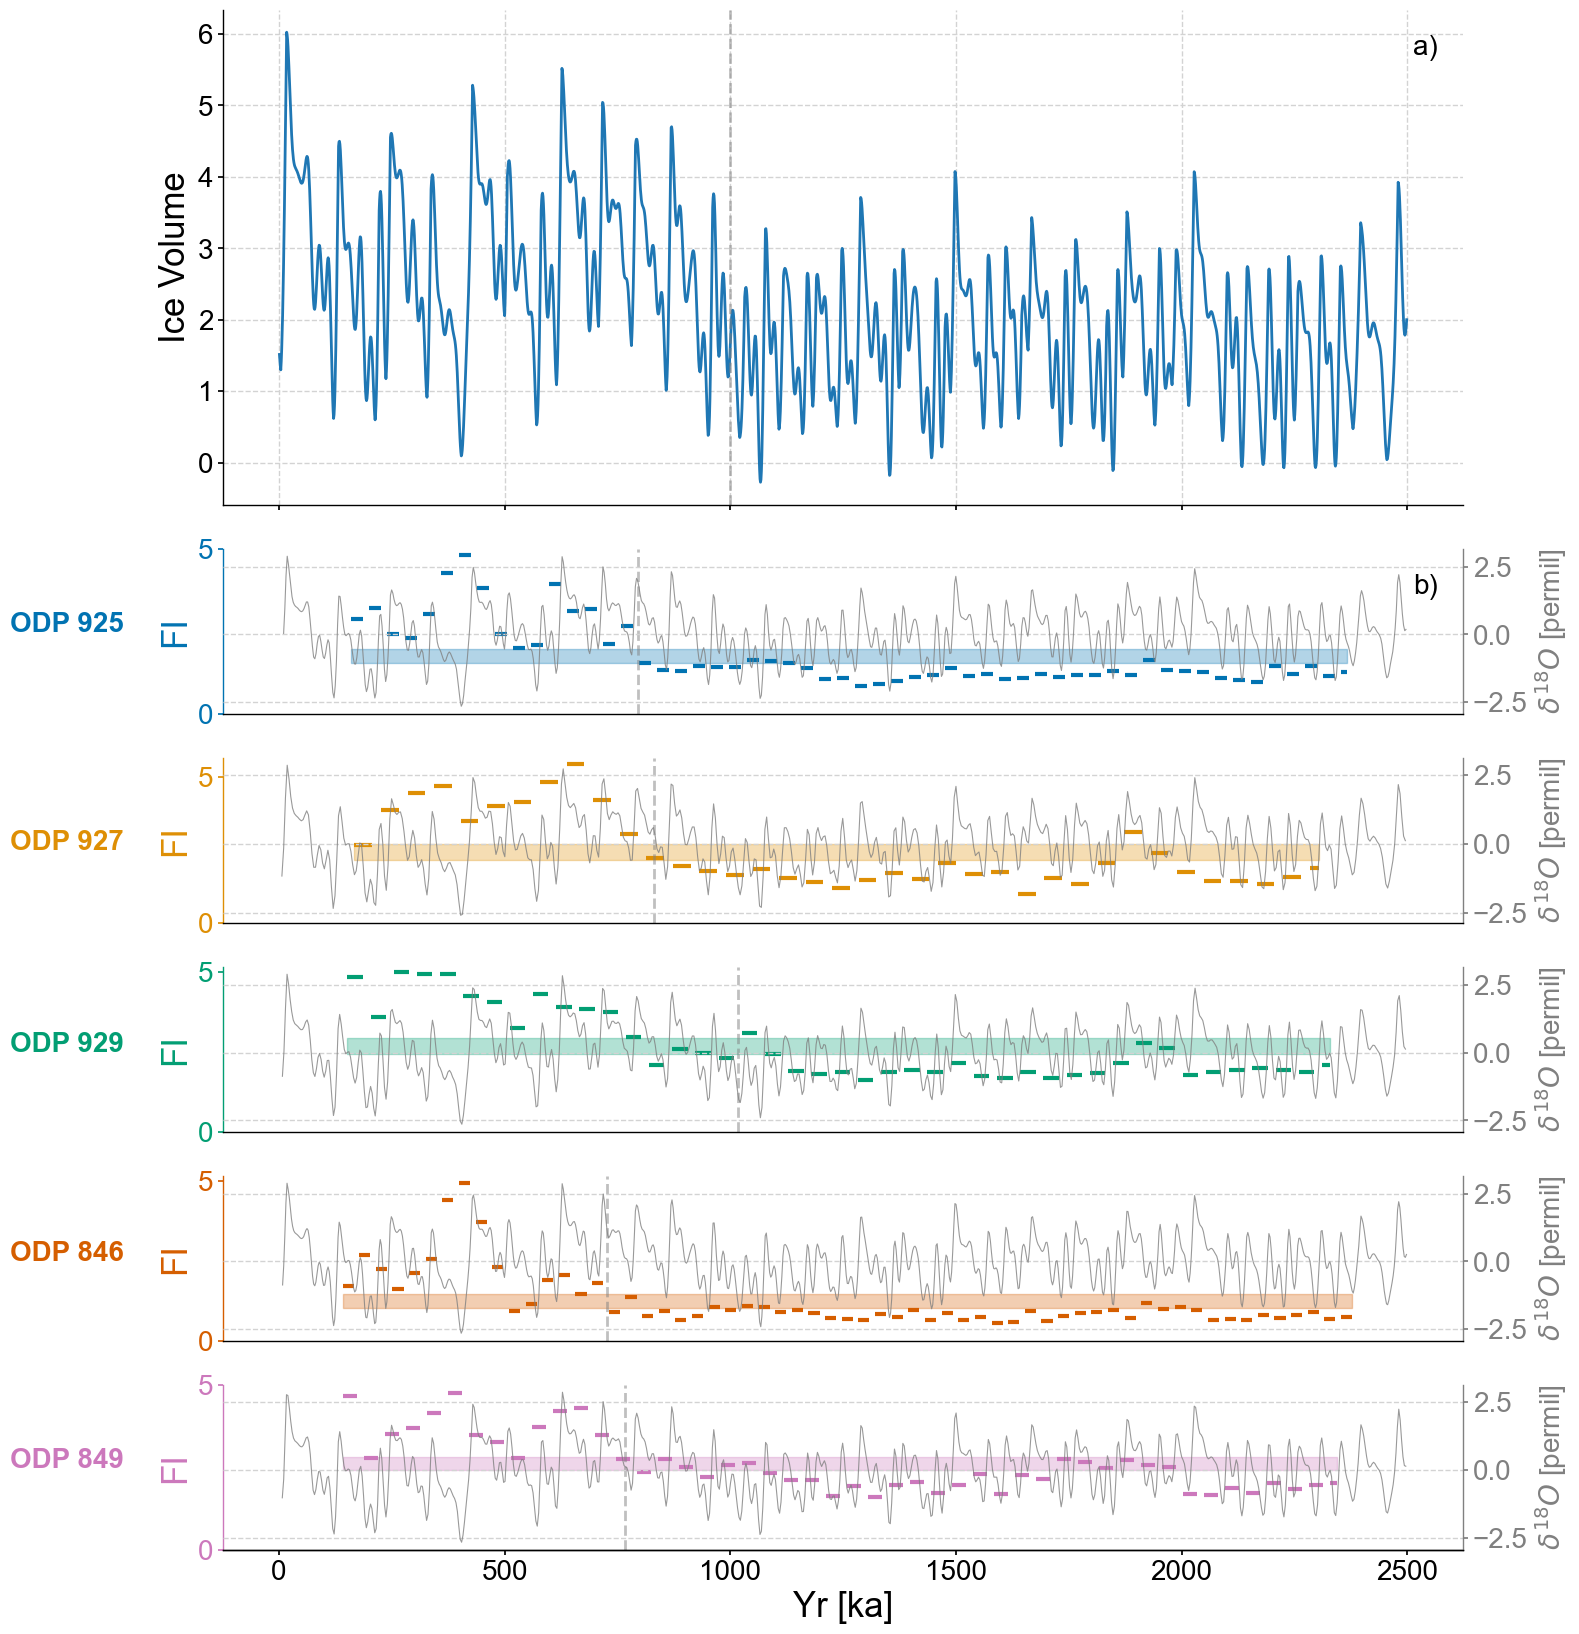

In [9]:
#Production figure

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(group_names)+1,ncols=1,sharex=True,figsize=(16,20),gridspec_kw={'height_ratios':[3,1,1,1,1,1]})
transition_timing = []

initial_series.plot(xlabel='',legend=False,ax=axes[0])
axes[0].yaxis.label.set_fontsize(25)
axes[0].axvline(1000,color='grey',linestyle='dashed',alpha=.5)

for idx,lp_series in enumerate(lp_series_list):
    ts = lp_series
    ts.label = lp_series.label
    ts.value_name = 'FI'
    ts.value_unit = None
    ts.time_name = 'Yr'
    ts.time_unit = 'ka'

    ax = axes[idx+1]
    ts_smooth = amt.utils.fisher.smooth_series(series=ts,block_size=3) #Using a block size of 3 for smoothing the Fisher information
    upper, lower = amt.utils.sampling.confidence_interval(series=ts,upper=95,lower=5,w=50,n_samples=10000) #Calculating the bounds for our confidence interval using default values 
    transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))

    transition_timing.append(transitions[np.abs(transitions-950)==np.min(np.abs(transitions-950))])

    ts.confidence_smooth_plot(
        ax=ax,
        background_series = syn_ms.series_list[idx].convert_time_unit('ka'),
        transition_interval=(upper,lower),
        block_size=3,
        color=color_list[idx],
        figsize=(12,6),
        legend=True,
        lgd_kwargs={'loc':'upper left'},
        hline_kwargs={'label':None},
        background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False,'linewidth':.8,'color':'grey','alpha':.8})

    ax.axvline(transition_timing[idx],color='grey',linestyle='dashed',alpha=.5)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(x=-.08, y = 2.5, s = ts.label, horizontalalignment='right', transform=trans, color=color_list[idx], weight='bold',fontsize=20)
        
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    ax.get_legend().remove()
    ax.set_title(None)
    ax.grid(visible=False,axis='y')
    if idx != len(group_names)-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_yticks(ticks=np.array([0,5]))

patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='a)')
axes[0].legend(handles=[patch],loc='upper right')

patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='b)')
axes[1].legend(handles=[patch],loc='upper right')

Checking the stats of the transition timings:

In [10]:
np.std(transition_timing)

100.88825925643162

In [11]:
np.mean(transition_timing)

827.7037375197435